# Cait probabilities

These are notes on probabilities when grinding for Evasive Manoeuvres. Comparing, in particular, Cait probabilities with Whistlewood's.

## Preliminaries

This section contains technical material necessary for running the notebook. It is irrelevant to the calculation themselves.

In [1]:
from IPython.display import display, Markdown

def VegaLite(spec):
    bundle = {}
    bundle['application/vnd.vegalite.v4+json'] = spec
    display(bundle, raw=True)

A generic printer for probabilities.

In [2]:
def PrintDict(pr,dict):
    out = ''
    for key, v in dict.items():
        out += '- **{:s}**: {:s}\n'.format(key,pr(v))
    display(Markdown(out))

The following helper functions prints a probability and a dictionary of probabilities as percentages

In [3]:
def PrintProba(p):
    return '{:.2f}%'.format(p*100)
def PrintProbas(dict):
    PrintDict(PrintProba, dict)

## Parameters

In this section, I configure the problem.

### Probabilities

The [probability of getting a Cait](https://octopathtraveler.fandom.com/wiki/Cait) in an encounter varies depending on the area. But as far as I can tell, in the areas we are interested in, the probability is always 3%. As far as I understand, this is the probability for an encounter to have a Cait, the Cait then replaces a random ennemy in that encounter.

The probabilities for Whistlewood's encounter are taken from [this wiki page](https://octopathtraveler.fandom.com/wiki/The_Whistlewood).

In [4]:
probabilities = {
  'cait': 0.03,
  'bugs + froggen IV': 0.1,
  'bugs + froggen V': 0.1,
  '5 bugs': 0.05,
  'howlers': 0.08,
}

### Routes

My second parameter is to classify the various encounters into their respective routes, and order the routes. In `route_spec` below, it is assumed that each route accepts the encounters of previous routes.

In [5]:
route_spec = [
    ('Cait', ['cait']),
    ('Whistlewood (no lightning)', ['bugs + froggen IV', 'bugs + froggen V', '5 bugs']),
    ('Whistlewood (with lightning)', ['howlers']),
]

 The definition of `route_spec` is a bit idiosyncratic, but from `route_spec`, I can derive two values:

- `routes`: the list of all the routes, ordered by desirability. It is used in the graph generation below to order the legend for the colours. It's purely cosmetic, but eases reading
- `result_types`: a dictionary mapping routes $r$ to rolls which allow a route _at least as good_ as $r$

These are the parameters used in the rest of the exploration: they are idiomatic Python values. But it's much more convenient to derive them from a single `route_spec`.

In [6]:
routes = [ route for route,result in route_spec]

In [7]:
display(routes)

['Cait', 'Whistlewood (no lightning)', 'Whistlewood (with lightning)']

In [8]:
from itertools import accumulate
def join(prev, cur):
    return (cur[0], prev[1]+cur[1])
result_types = dict(accumulate(route_spec,join))

In [9]:
display(result_types)

{'Cait': ['cait'],
 'Whistlewood (no lightning)': ['cait',
  'bugs + froggen IV',
  'bugs + froggen V',
  '5 bugs'],
 'Whistlewood (with lightning)': ['cait',
  'bugs + froggen IV',
  'bugs + froggen V',
  '5 bugs',
  'howlers']}

## Some calculations

Now, what I'm ultimately interested in are the probabilities of getting a good encounter in the various routes. The goal is to answer questions of the sort: how many encounters must I expect if I go for this route.

There are some limitations to the probabilities calculations. In particular, good Whistlewood encounters have 3% chance of having a Cait, these encounters are counter twice (this overestimates the probabilities by 0.75 percentage points); less significant, there is a fight that we can't beat in Whistlewood (2x Spud Bug + 1x Flatlands Froggen VI), if this encounter has a Cait then it has 2/3 chance of being unkillable (that is, unless the Froggen is replaced by the Cait), whihch overestimates the probability by 0.06 percentage point), if you have no lightning, the same issue occurs with the Howler encounter (0.24 percentage point).

So the real probability for a good encounter in Whistlewood with no lighthning is 26.95%. It's close enough, though, and I had this code handy. I didn't want to input manual calculations in because they are hard to maintain.

I also have no idea what the probabilities of a surprise attack is, but we should, in principle, count surprise attacks, in Whistlewood, as bad encounters, as we die before we can kill them.

In [10]:
def subdict (keys):
    dict = {}
    for k in keys:
        dict[k] = probabilities[k]
    return dict

In [11]:
classified_probabilities = dict([(route, subdict(entries)) for route,entries in result_types.items()])

In [12]:
route_probabilities = { route: sum(results.values()) for route,results in classified_probabilities.items() }

In [13]:
PrintProbas(route_probabilities)

- **Cait**: 3.00%
- **Whistlewood (no lightning)**: 28.00%
- **Whistlewood (with lightning)**: 36.00%


## Drawing a graph

Let me summarise the probability in the form of a graph. We can easily read, in the graph, how many encounters it take to have x% change of success.

The probability of at least one of these encounters being good is computed using the classic formula for [Bernoulli trials](https://en.wikipedia.org/wiki/Bernoulli_trial).

$$
1 - (1-p)^n
$$

Where $p$ is the probability of one roll succeeding, and $n$ is the number of encounters.

In [14]:
def attempts(p, n):
  return (1-(1-p)**n)

To draw the graph, I need to decide up to how many attempts I'm going to draw. I'm taking 60 because the graph becomes pretty unreadable beyond that. Despite the fact that the probability to get a Cait in 60 attempts is not even 90%.

In [15]:
max_attempts=60
print(PrintProba(attempts(route_probabilities['Cait'],max_attempts)))

83.92%


In fact, we would need 100 encounters to have 95% chance of finding a Cait.

In [16]:
print(PrintProba(attempts(route_probabilities['Cait'],100)))

95.24%


In [17]:
def gen():
    for n in range(max_attempts+1):
        for route, p in route_probabilities.items():
            yield { '# Attempts': n, 'Probability': attempts(p,n), 'Route': route }
data = list(gen())

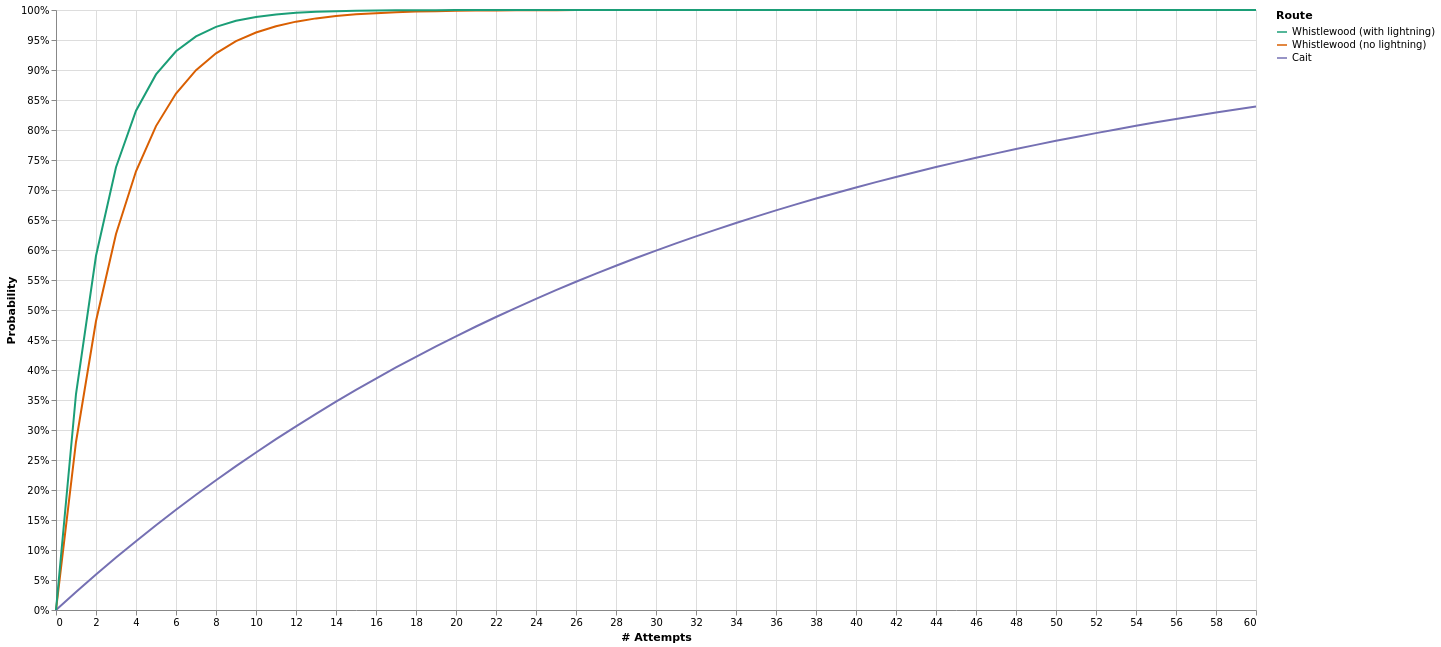

In [18]:
VegaLite({
  "$schema": "https://vega.github.io/schema/vega-lite/v4.json",
  "width": 1200,
  "height": 600,
  "padding": 5,
  "data": {
    "values": data
  },
  "mark": "line",
  "encoding": {
    "x": {"field": "# Attempts", "type": "quantitative"},
    "y": {"field": "Probability", "type": "quantitative", "axis": {"format": ".0%"}},
    "color": {"field": 'Route', "sort": reversed(routes), "scale": {"scheme": "dark2"}},
  }
})

## Expected number of tries

A natural question is “how many number of tries will I have to do, on average, until I get a given result”. It turns out to be very simple to calculate. If I write $N$ for the number of tries I do until I get a result of probability $p$ ($N$ is a [random variable](https://en.wikipedia.org/wiki/Random_variable)), then

$$
E(N) = \frac{1}{p}
$$

Here is a [blog post](https://adhocery.wordpress.com/2011/02/11/expected-number-of-trials-until-success-of-a-bernoulli-random-variable/) where the value is worked out from the elementary fact that 

$$
P(N=k) = p(1-p)^{k-1}
$$

While researching this question I found that the probability distribution associated to $N$ was called a [_geometric distribution_](https://en.wikipedia.org/wiki/Geometric_distribution).

So we compute the average number of Bewildering Grace x4 attempts to do to get (a route at least as good as a given route).

In [19]:
route_expectations = { key: 1/p for key,p in route_probabilities.items() }
PrintDict((lambda n: '{:.2f}'.format(n)), route_expectations)

- **Cait**: 33.33
- **Whistlewood (no lightning)**: 3.57
- **Whistlewood (with lightning)**: 2.78
